https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

Using TensorFlow backend.


In [2]:
strFileName = '/Users/gauchetvanantwerpen/Documents/01 gvaLokaalDocs/01 Pers/02 Nisse/02 development/02 nissedb/results/jsebased.csv'

In [3]:
# gva load dataset

dataset = read_csv(strFileName, header=0, index_col=0, engine='python')

dataset.drop(['cluster_labels','anomaly_score','moex_Close','ks11_Close'], axis=1, inplace=True)

dataset.head()

,sp500_Close,jse_Close,ftse_Close,gdax_Close,hsng_Close,nikk_Close
Date,,,,,,
2006-06-05T00:00:00.000000Z,1265.290039,1563.361450,5762.100098,5621.189941,16016.230469,311.160004
2006-06-06T00:00:00.000000Z,1263.849976,1417.662842,5669.799805,5502.810059,15973.110352,306.170013
2006-06-07T00:00:00.000000Z,1256.150024,1347.391846,5706.299805,5543.930176,15816.549805,299.920013
2006-06-08T00:00:00.000000Z,1257.930054,1289.370483,5562.899902,5383.279785,15450.110352,290.290009
2006-06-09T00:00:00.000000Z,1252.300049,1482.776123,5655.200195,5464.080078,15628.690430,292.880005


In [4]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

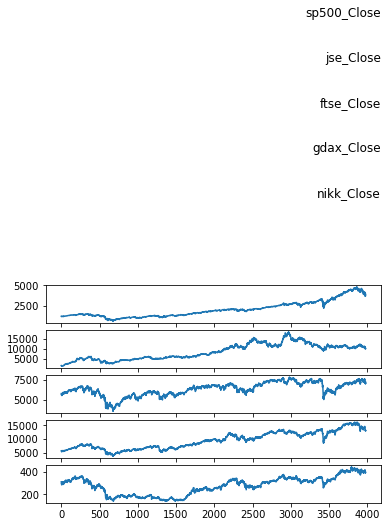

In [90]:
years=8

# load dataset
#dataset = read_csv(strFileName, header=0, index_col=0)

#dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=years, loc='right')
    i += 1
pyplot.show()

In [91]:
# integer encode direction
encoder = LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])
# ensure all data is float
values = values.astype('float32')
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)


In [92]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)

reframed.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var1(t)', 'var2(t)', 'var3(t)', 'var4(t)', 'var5(t)',
       'var6(t)'],
      dtype='object')

In [93]:
# drop columns we don't want to predict
reframed.drop(reframed.columns[[7,8,9,10,11]], axis=1, inplace=True)
print(reframed.head())

   var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)   var1(t)
1   0.142902   0.016546   0.515417   0.155076   0.039339   0.565944  0.142552
2   0.142552   0.007982   0.494273   0.145684   0.038815   0.549371  0.140683
3   0.140683   0.003852   0.502634   0.148946   0.037503   0.528613  0.141115
4   0.141115   0.000441   0.469785   0.136202   0.031734   0.496629  0.139749
5   0.139749   0.011809   0.490929   0.142612   0.035143   0.505231  0.136142


In [94]:
#GVA
# split into train and test sets

# split into train and test sets
values = reframed.values

train_size = int(len(values) * 0.67)
test_size = len(values) - train_size
train, test = values[0:train_size,:], values[train_size:len(values),:]
print(len(train), len(test))

2296 1132


In [95]:
train.shape

(2296, 7)

In [96]:
test.shape

(1132, 7)

In [97]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(2296, 1, 6) (2296,) (1132, 1, 6) (1132,)


In [98]:
# design network
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')


In [99]:
# fit network
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Train on 2296 samples, validate on 1132 samples
Epoch 1/50
 - 1s - loss: 0.0730 - val_loss: 0.1662
Epoch 2/50
 - 0s - loss: 0.0727 - val_loss: 0.2090
Epoch 3/50
 - 0s - loss: 0.0488 - val_loss: 0.1795
Epoch 4/50
 - 0s - loss: 0.0417 - val_loss: 0.1615
Epoch 5/50
 - 0s - loss: 0.0371 - val_loss: 0.1576
Epoch 6/50
 - 0s - loss: 0.0318 - val_loss: 0.1560
Epoch 7/50
 - 0s - loss: 0.0289 - val_loss: 0.1538
Epoch 8/50
 - 0s - loss: 0.0271 - val_loss: 0.1541
Epoch 9/50
 - 0s - loss: 0.0250 - val_loss: 0.1519
Epoch 10/50
 - 0s - loss: 0.0238 - val_loss: 0.1536
Epoch 11/50
 - 0s - loss: 0.0226 - val_loss: 0.1510
Epoch 12/50
 - 0s - loss: 0.0221 - val_loss: 0.1509
Epoch 13/50
 - 0s - loss: 0.0213 - val_loss: 0.1497
Epoch 14/50
 - 0s - loss: 0.0209 - val_loss: 0.1470
Epoch 15/50
 - 0s - loss: 0.0204 - val_loss: 0.1463
Epoch 16/50
 - 0s - loss: 0.0194 - val_loss: 0.1451
Epoch 17/50
 - 0s - loss: 0.0185 - val_loss: 0.1441
Epoch 18/50
 - 0s - loss: 0.0175 - val_loss: 0.1445
Epoch 19/50
 - 0s - loss:

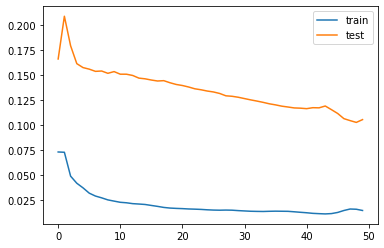

In [100]:
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [103]:
n_hours = 2
n_features = 3
# make a prediction
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0], n_hours*n_features))
# invert scaling for forecast
inv_yhat = concatenate((yhat, test_X[:, -7:]), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,0]
# invert scaling for actual
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_y, test_X[:, -7:]), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,0]
# calculate RMSE
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)

ValueError: Error when checking input: expected lstm_7_input to have 3 dimensions, but got array with shape (1132, 6)